In [24]:
import os
import sys

# Add the parent directory to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

# Now you can import the module from the examples directory
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.sparse import csc_matrix
import networkx as nx
from l2ws.utils.nn_utils import get_nearest_neighbors
from l2ws.scs_model import SCSmodel
from l2ws.algo_steps import create_M, get_scaled_vec_and_factor, create_projection_fn
from jax import lax
from l2ws.utils.generic_utils import setup_permutation


## SCS

In this tutorial we show how to use our package to learn high-quality warm starts for your favorite fixed-point algorithm.
We consider projected gradient descent to solve the problem

\begin{array}{ll} \text{minimize} & 1 / 2 x^T P x + c^T x
\\ \text{subject to} \quad & Ax + s = b\\
&s \in \mathcal{K}
 \end{array}
where $x \in \mathbf{R}^n$ and $s \in \mathbf{R}^m$ are the decision variables.
Here, $P \in \mathbf{S}_+^n$, $A \in \mathbf{R}^{m \times n}$, $c \in \mathbf{R}^n$, and $b \in \mathbf{R}^m$ are the problem data.


We take the specific example of the semidefinite relaxation to maxcut

\begin{array}{ll} \rm{minimize} &\mathbf{tr}(CX) \\
\text{subject to} &X_{ii} = 1 \quad i=1,\dots,n \\
&X \succeq 0
 \end{array}
where $C \in \mathbf{S}^{n}$ is the problem data.
Here, $\theta = \mathbf{vec}(C)$ is the parameter.

In [2]:
# create the cvxpy problem
n_orig = 10
nc2 = int(n_orig * (n_orig + 1) / 2)
N_train = 5000
N_test = 100
N = N_train + N_test

C_param = cp.Parameter((n_orig, n_orig), symmetric=True)
X = cp.Variable((n_orig, n_orig), symmetric=True)
prob = cp.Problem(cp.Maximize(cp.trace(C_param @ X)), constraints=[X >> 0, cp.diag(X) == 1])

In [3]:
# create the C matrices
laplacian_matrices = []
laplacian_matrices_upper_tri_mat = np.zeros((N, nc2))

# Create the nominal graph (you can customize this)
nominal_graph = nx.erdos_renyi_graph(n_orig, 0.5)

probability = 0.2

for i in range(N):
    perturbation_matrix = np.random.rand(n_orig, n_orig) < probability
    perturbation_matrix = (perturbation_matrix + perturbation_matrix.T) / 2

    # Create a graph centered around the nominal graph by combining it with the perturbation
    G = nx.Graph(np.minimum(nx.to_numpy_array(nominal_graph) + perturbation_matrix, 1))

    # Compute the Laplacian matrix of the graph
    laplacian_matrix = nx.laplacian_matrix(G).toarray()
    
    laplacian_matrices.append(laplacian_matrix)
    laplacian_matrices_upper_tri_mat[i, :] = laplacian_matrix[np.triu_indices(laplacian_matrix.shape[0])]

In [4]:
C_param.value = laplacian_matrices[0]
prob.solve()
data, _, __ = prob.get_problem_data(cp.SCS)
c, b = data['c'], data['b']
A = data['A']

m = b.size
n = c.size
P = csc_matrix(np.zeros((n, n)))

cones_cp = data['dims']
cones = {'z': cones_cp.zero, 'l': cones_cp.nonneg, 'q': cones_cp.soc, 's': cones_cp.psd}

q_mat = np.zeros((N, m + n))
z_stars = np.zeros((N, m + n))
x_stars = np.zeros((N, n))
y_stars = np.zeros((N, m))
for i in range(N):
    C_param.value = laplacian_matrices[i]
    sol = prob.solve()
    data, _, __ = prob.get_problem_data(cp.SCS)
    c, b = data['c'], data['b']

    # q = (c, b)
    q_mat[i, :n] = c
    q_mat[i, n:] = b

    # get the optimal solution
    x_star = prob.solution.attr['solver_specific_stats']['x']
    y_star = prob.solution.attr['solver_specific_stats']['y']
    s_star = prob.solution.attr['solver_specific_stats']['s']

    # transform the solution to the z variable
    z_star = np.concatenate([x_star, y_star + s_star])
    z_stars[i, :] = z_star
    x_stars[i, :] = x_star
    y_stars[i, :] = y_star



In [5]:
# SCS algorithm hyperparameters
rho_x, alpha, scale = 1, 1, 1
zero_cone_size = cones['z']
P_jax = jnp.array(P.todense())
A_jax = jnp.array(A.todense())
M_jax = create_M(P_jax, A_jax)
algo_factor, scale_vec = get_scaled_vec_and_factor(M_jax, rho_x, scale, m, n,
                                                        zero_cone_size)

In [6]:
q_mat_jax = jnp.array(q_mat)
theta_mat_jax = jnp.array(laplacian_matrices_upper_tri_mat)


In [7]:
projection = create_projection_fn(cones, n)
q_mat_train = q_mat_jax[:N_train, :]
q_mat_test = q_mat_jax[N_train:, :]
train_inputs = theta_mat_jax[:N_train, :]
test_inputs = theta_mat_jax[N_train:, :]
z_stars_jax = jnp.array(z_stars)
z_stars_train = z_stars_jax[:N_train, :]
z_stars_test = z_stars_jax[N_train:, :]
x_stars_jax = jnp.array(x_stars)
x_stars_train = x_stars_jax[:N_train, :]
x_stars_test = x_stars_jax[N_train:, :]
y_stars_jax = jnp.array(y_stars)
y_stars_train = y_stars_jax[:N_train, :]
y_stars_test = y_stars_jax[N_train:, :]

train_unrolls = 5
supervised = True

nn_cfg = {'lr': 1e-3, 'method': 'adam', 'intermediate_layer_sizes': [200], 'batch_size': 100}
input_dict = dict(algorithm='scs',
                  nn_cfg=nn_cfg,
                      m=m, n=n, hsde=True, static_flag=True, proj=projection,
                      supervised=supervised,
                      cones=cones,
                      train_unrolls=train_unrolls, jit=True,
                      q_mat_train=q_mat_train, q_mat_test=q_mat_test,
                      train_inputs=train_inputs, test_inputs=test_inputs,
                      static_M=M_jax,
                      static_algo_factor=algo_factor,
                      rho_x=rho_x, scale=scale, alpha_relax=alpha,
                      zero_cone_size=zero_cone_size,
                      x_stars_train=x_stars_train,
                      x_stars_test=x_stars_test,
                      y_stars_train=y_stars_train,
                      y_stars_test=y_stars_test,
                      z_stars_train=z_stars_train,
                      z_stars_test=z_stars_test)
scs_model = SCSmodel(input_dict)

In [8]:
# cold start evaluation
k = 100

# test problems
init_eval_out = scs_model.evaluate(
    k, test_inputs, q_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
init_test_losses = init_eval_out[1][1].mean(axis=0)

# train problems
init_eval_train_out = scs_model.evaluate(
    k, train_inputs, q_mat_train, z_stars=z_stars_train, fixed_ws=False, tag='test')
init_train_losses = init_eval_train_out[1][1].mean(axis=0)

In [9]:
# full evaluation on the test set with nearest neighbor
nearest_neighbors_z = get_nearest_neighbors(train_inputs, test_inputs, z_stars_train)
nn_eval_out = scs_model.evaluate(k, nearest_neighbors_z,
                                    q_mat_test, z_stars=z_stars_test,
                                    fixed_ws=True, tag='test')
nn_losses = nn_eval_out[1][1].mean(axis=0)

In [10]:
def train_jitted_epochs(scs_model, permutation, epoch, num_batches, epochs_jit):
        """
        train self.epochs_jit at a time
        special case: the first time we call train_batch (i.e. epoch = 0)
        """
        def train_over_epochs_body_simple_fn(batch, val):
            """
            to be used as the body_fn in lax.fori_loop
            need to call partial for the specific permutation
            """
            train_losses, params, state, permutation = val
            start_index = batch * scs_model.batch_size
            batch_indices = lax.dynamic_slice(
                permutation, (start_index,), (scs_model.batch_size,))
            train_loss, params, state = scs_model.train_batch(
                batch_indices, params, state)
            train_losses = train_losses.at[batch].set(train_loss)
            val = train_losses, params, state, permutation
            return val

        # epoch_batch_start_time = time.time()
        loop_size = int(num_batches * epochs_jit)
        epoch_train_losses = jnp.zeros(loop_size)
        if epoch == 0:
            # unroll the first iterate so that This allows `init_val` and `body_fun`
            #   below to have the same output type, which is a requirement of
            #   lax.while_loop and lax.scan.
            batch_indices = lax.dynamic_slice(
                permutation, (0,), (scs_model.batch_size,))
            
            train_loss_first, params, state = scs_model.train_batch(
                batch_indices, scs_model.params, scs_model.state)

            epoch_train_losses = epoch_train_losses.at[0].set(train_loss_first)
            start_index = 1
            train_over_epochs_body_simple_fn_jitted = train_over_epochs_body_simple_fn
        else:
            start_index = 0
            params, state = scs_model.params, scs_model.state

        init_val = epoch_train_losses, params, state, permutation

        val = lax.fori_loop(start_index, loop_size, train_over_epochs_body_simple_fn_jitted, init_val)
        epoch_train_losses, params, state, permutation = val
        return params, state, epoch_train_losses

    

In [11]:
epoch = 0
num_epochs = 200
num_batches = int(N_train / scs_model.batch_size)

permutation = setup_permutation(1, N_train, num_epochs)
params, state, train_losses = train_jitted_epochs(scs_model, permutation, epoch, num_batches, num_epochs)
scs_model.params = params
scs_model.state = state


In [12]:
# full evaluation on the test set
final_eval_out = scs_model.evaluate(
    k, test_inputs, q_mat_test, z_stars=z_stars_test, fixed_ws=False, tag='test')
final_test_losses = final_eval_out[1][1].mean(axis=0)

# full evaluation on the train set
final_eval_train_out = scs_model.evaluate(
    k, train_inputs, q_mat_train, z_stars=z_stars_train, fixed_ws=False, tag='train')
final_train_losses = final_eval_train_out[1][1].mean(axis=0)

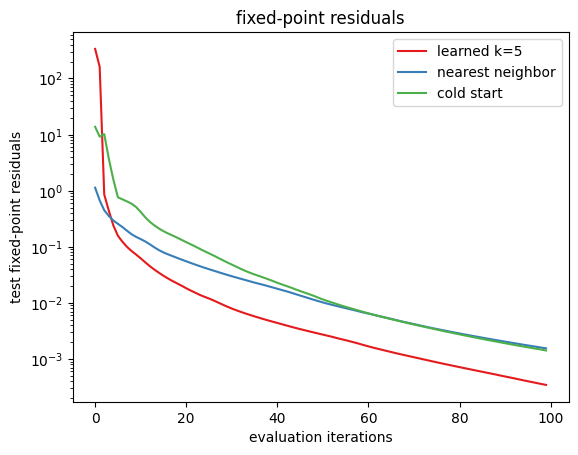

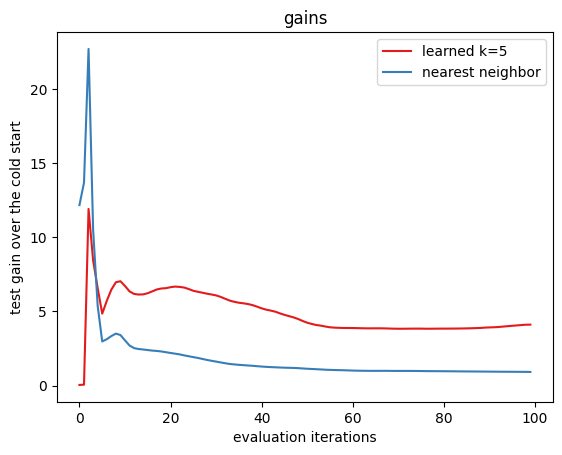

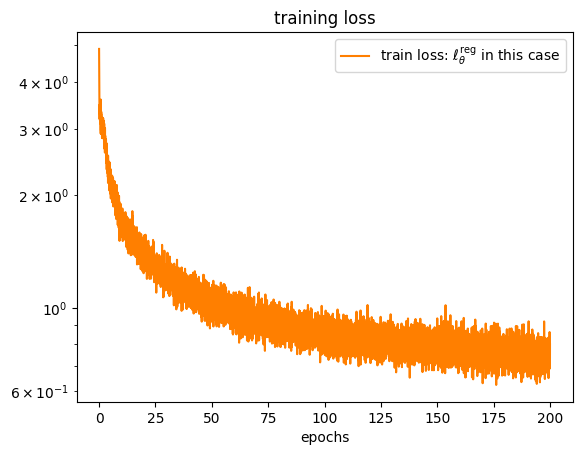

In [13]:
# test results
plt.plot(final_test_losses, label=f"learned k={train_unrolls}")
plt.plot(nn_losses, label='nearest neighbor')
plt.plot(init_test_losses, label='cold start')
plt.yscale('log')
plt.title('fixed-point residuals')
plt.ylabel('test fixed-point residuals')
plt.xlabel('evaluation iterations')
plt.legend()
plt.show()

plt.plot(init_test_losses / final_test_losses, label=f"learned k={train_unrolls}")
plt.plot(init_test_losses / nn_losses, label='nearest neighbor')
plt.title('gains')
plt.ylabel('test gain over the cold start')
plt.xlabel('evaluation iterations')
plt.legend()
plt.show()

label=r'train loss: $\ell^{\rm reg}_\theta$ in this case' if supervised else r'train loss: $\ell^{\rm fp}_\theta$ in this case'
batches_per_epoch = N_train / scs_model.batch_size
plt.plot(np.arange(train_losses.size) / batches_per_epoch, train_losses, label=label)
plt.yscale('log')
test_losses = np.array([init_test_losses[train_unrolls], final_test_losses[train_unrolls]])
epochs_array = np.array([0, num_epochs])

# test_label = r'test fixed-point residual: $\ell^{\rm fp}_\theta$'
# plt.plot(epochs_array, test_losses, label=test_label, color=colors[3])
# plt.ylabel('loss')
plt.xlabel('epochs')
plt.yscale('log')
plt.title('training loss')
plt.legend()
plt.show()

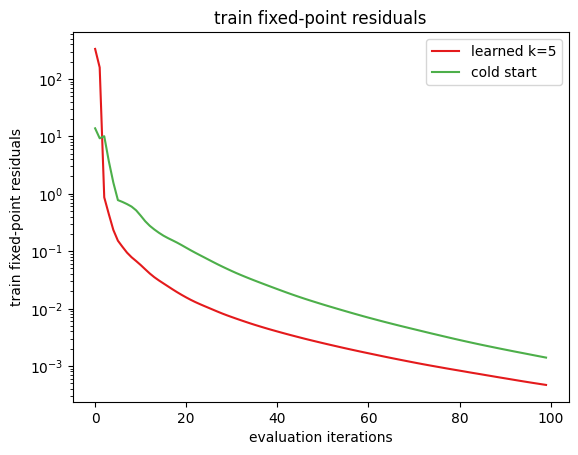

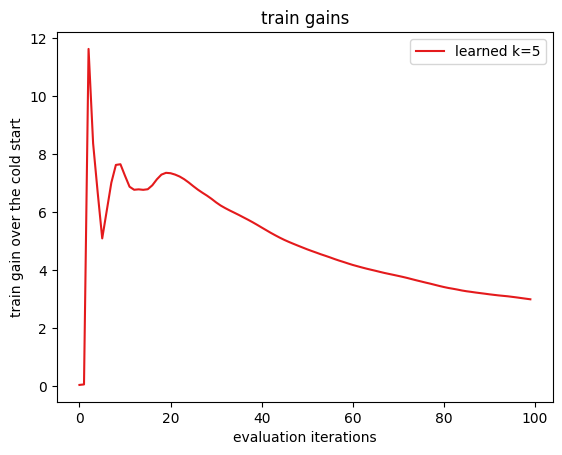

In [14]:
# train results
plt.plot(final_train_losses, label=f"learned k={train_unrolls}")
plt.plot(init_train_losses, label='cold start')
plt.yscale('log')
plt.title('train fixed-point residuals')
plt.ylabel('train fixed-point residuals')
plt.xlabel('evaluation iterations')
plt.legend()
plt.show()

plt.plot(init_train_losses / final_train_losses, label=f"learned k={train_unrolls}")
plt.title('train gains')
plt.ylabel('train gain over the cold start')
plt.xlabel('evaluation iterations')
plt.legend()
plt.show()

In [20]:
# run the learned warm starts with SCS code
z0_mat = final_eval_out[1][2][:, 0, :]
final_solve_times_mean = []
final_solve_iters_mean = []

tols = [1e-2, 1e-3, 1e-4, 1e-5]
for i in range(len(tols)):
    rel_tol = tols[i]
    abs_tol = tols[i]
    solve_times, solve_iters, x_sols, y_sols = scs_model.solve_c(z0_mat, q_mat_test, rel_tol, abs_tol)
    final_solve_times_mean.append(solve_times.mean())
    final_solve_iters_mean.append(solve_iters.mean())

In [21]:
# run the cold starts with SCS code
z0_mat = init_eval_out[1][2][:, 0, :]
init_solve_times_mean = []
init_solve_iters_mean = []

tols = [1e-2, 1e-3, 1e-4, 1e-5]
for i in range(len(tols)):
    rel_tol = tols[i]
    abs_tol = tols[i]
    solve_times, solve_iters, x_sols, y_sols = scs_model.solve_c(z0_mat, q_mat_test, rel_tol, abs_tol)
    init_solve_times_mean.append(solve_times.mean())
    init_solve_iters_mean.append(solve_iters.mean())

In [22]:
# run the nearest neighbor warm start with SCS code
z0_mat = nn_eval_out[1][2][:, 0, :]
nn_solve_times_mean = []
nn_solve_iters_mean = []

tols = [1e-2, 1e-3, 1e-4, 1e-5]

for i in range(len(tols)):
    rel_tol = tols[i]
    abs_tol = tols[i]
    solve_times, solve_iters, x_sols, y_sols = scs_model.solve_c(z0_mat, q_mat_test, rel_tol, abs_tol)
    nn_solve_times_mean.append(solve_times.mean())
    nn_solve_iters_mean.append(solve_iters.mean())

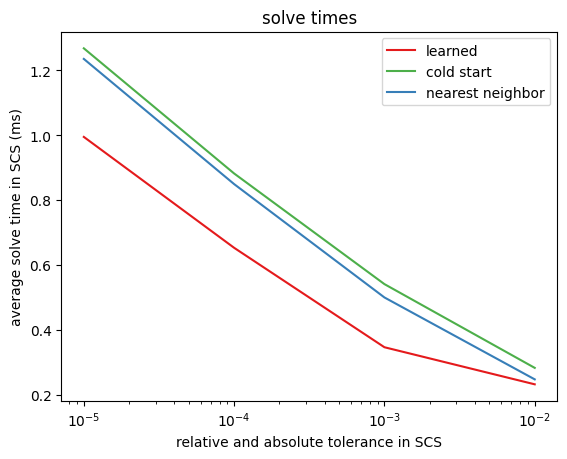

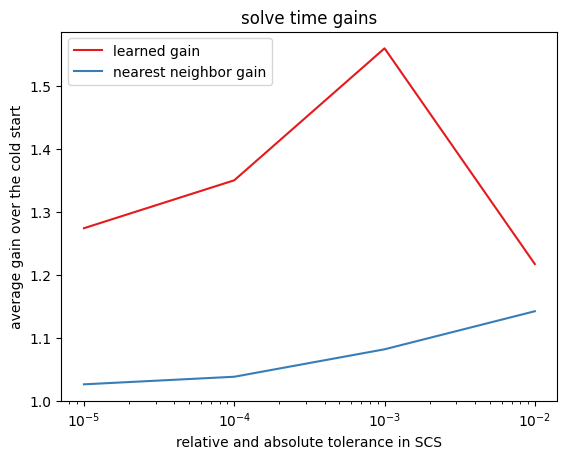

In [23]:
plt.plot(tols, final_solve_times_mean, label='learned')
plt.plot(tols, nn_solve_times_mean, label='nearest neighbor')
plt.plot(tols, init_solve_times_mean, label='cold start')
plt.xscale('log')
plt.ylabel('average solve time in SCS (ms)')
plt.xlabel('relative and absolute tolerance in SCS')
plt.title('solve times')
plt.legend()
plt.show()

plt.plot(tols, np.array(init_solve_times_mean) / np.array(final_solve_times_mean), label='learned gain')
plt.plot(tols, np.array(init_solve_times_mean) / np.array(nn_solve_times_mean), label='nearest neighbor gain')
plt.xscale('log')
plt.ylabel('average gain over the cold start')
plt.xlabel('relative and absolute tolerance in SCS')
plt.title('solve time gains')
plt.legend()
plt.show()